In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
OUT_CSV_DIR = "results"
OUT_PLOT_DIR = "plots"
os.makedirs(OUT_CSV_DIR, exist_ok=True)
os.makedirs(OUT_PLOT_DIR, exist_ok=True)

In [6]:
# Read Data
CSV_FILE = "Fire Incidents Data.csv"

print("Loading data:", CSV_FILE)
df = pd.read_csv(CSV_FILE, low_memory=False)

Loading data: Fire Incidents Data.csv


In [7]:
# to date
date_cols = ["TFS_Alarm_Time","TFS_Arrival_Time","Fire_Under_Control_Time"]
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

In [8]:
# to numeric
num_cols = ["Estimated_Dollar_Loss","Civilian_Casualties","Count_of_Persons_Rescued",
            "Estimated_Number_Of_Persons_Displaced","Number_of_responding_apparatus",
            "Number_of_responding_personnel","TFS_Firefighter_Casualties"]
for c in num_cols:
    if c in df.columns:
        # try to coerce numeric, replace non-numeric with NaN
        df[c] = pd.to_numeric(df[c], errors="coerce")

In [9]:
# compute Response_Minutes and Minutes_To_Control
if "TFS_Alarm_Time" in df.columns and "TFS_Arrival_Time" in df.columns:
    df["Response_Minutes"] = (df["TFS_Arrival_Time"] - df["TFS_Alarm_Time"]).dt.total_seconds() / 60.0
if "TFS_Alarm_Time" in df.columns and "Fire_Under_Control_Time" in df.columns:
    df["Minutes_To_Control"] = (df["Fire_Under_Control_Time"] - df["TFS_Alarm_Time"]).dt.total_seconds() / 60.0

In [11]:
# Helper: safe save CSV and plot
def save_csv(df_out, name):
    path = os.path.join(OUT_CSV_DIR, f"{name}.csv")
    df_out.to_csv(path, index=False)
    print("Saved CSV:", path)

def save_plot(fig, name):
    path = os.path.join(OUT_PLOT_DIR, f"{name}.png")
    fig.savefig(path, bbox_inches='tight', dpi=150)
    plt.close(fig)
    print("Saved plot:", path)

In [12]:
# 1) Incidents by Year
if "TFS_Alarm_Time" in df.columns:
    df_year = df[df["TFS_Alarm_Time"].notna()].copy()
    df_year["Year"] = df_year["TFS_Alarm_Time"].dt.year
    q1 = df_year.groupby("Year").size().reset_index(name="Incidents")
    save_csv(q1, "incidents_by_year")
    fig = plt.figure(figsize=(8,4))
    plt.plot(q1["Year"], q1["Incidents"], marker='o')
    plt.title("Incidents by Year")
    plt.xlabel("Year"); plt.ylabel("Incidents")
    save_plot(fig, "incidents_by_year")

Saved CSV: results\incidents_by_year.csv
Saved plot: plots\incidents_by_year.png


In [13]:
# 2) Top Areas of Origin (top 10)
if "Area_of_Origin" in df.columns:
    q2 = df["Area_of_Origin"].value_counts().head(10).reset_index()
    q2.columns = ["Area_of_Origin","Incidents"]
    save_csv(q2, "top10_area_of_origin")
    fig = plt.figure(figsize=(8,4))
    plt.barh(q2["Area_of_Origin"][::-1], q2["Incidents"][::-1])
    plt.title("Top 10 Areas of Origin")
    save_plot(fig, "top10_area_of_origin")

Saved CSV: results\top10_area_of_origin.csv
Saved plot: plots\top10_area_of_origin.png


In [14]:
# 3) Avg Estimated Loss by Final Incident Type
if "Final_Incident_Type" in df.columns and "Estimated_Dollar_Loss" in df.columns:
    q3 = df.groupby("Final_Incident_Type")["Estimated_Dollar_Loss"].apply(lambda x: pd.to_numeric(x, errors="coerce").mean()).reset_index()
    q3 = q3.dropna().sort_values("Estimated_Dollar_Loss", ascending=False).head(20)
    q3.columns = ["Final_Incident_Type","Avg_Estimated_Loss"]
    save_csv(q3, "avg_loss_by_final_type")
    fig = plt.figure(figsize=(8,6))
    plt.barh(q3["Final_Incident_Type"][::-1], q3["Avg_Estimated_Loss"][::-1])
    plt.title("Avg Estimated Loss by Final Incident Type (top 20)")
    save_plot(fig, "avg_loss_by_final_type")

Saved CSV: results\avg_loss_by_final_type.csv
Saved plot: plots\avg_loss_by_final_type.png


In [15]:
# 4) Response Minutes vs Civilian Casualties (binned)
if "Response_Minutes" in df.columns and "Civilian_Casualties" in df.columns:
    tmp = df[~df["Response_Minutes"].isna()].copy()
    tmp["resp_bin"] = pd.cut(tmp["Response_Minutes"], bins=[-1,5,10,20,30,60,9999], labels=["<=5","6-10","11-20","21-30","31-60",">60"])
    q4 = tmp.groupby("resp_bin")["Civilian_Casualties"].sum().reset_index()
    save_csv(q4, "response_bin_vs_casualties")
    fig = plt.figure(figsize=(8,4))
    plt.bar(q4["resp_bin"].astype(str), q4["Civilian_Casualties"])
    plt.title("Response time bins vs total civilian casualties")
    plt.xlabel("Response time bin (minutes)"); plt.ylabel("Total Civilian Casualties")
    save_plot(fig, "response_bin_vs_casualties")

C:\Users\Ismail\AppData\Local\Temp\ipykernel_22100\3716811295.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q4 = tmp.groupby("resp_bin")["Civilian_Casualties"].sum().reset_index()


Saved CSV: results\response_bin_vs_casualties.csv
Saved plot: plots\response_bin_vs_casualties.png


In [16]:
# 5) Sprinkler presence/operation vs casualties & loss
if "Sprinkler_System_Presence" in df.columns:
    grp_cols = ["Sprinkler_System_Presence"]
    if "Sprinkler_System_Operation" in df.columns:
        grp_cols.append("Sprinkler_System_Operation")
    q5 = df.groupby(grp_cols).agg(
        Incidents=("Area_of_Origin","count"),
        Total_Civilian_Casualties=("Civilian_Casualties","sum"),
        Avg_Loss=("Estimated_Dollar_Loss", lambda s: pd.to_numeric(s, errors="coerce").mean())
    ).reset_index()
    save_csv(q5, "sprinkler_effect")
    fig = plt.figure(figsize=(8,4))
    # simple bar: incidents by presence
    pres = df["Sprinkler_System_Presence"].value_counts().head(20)
    plt.bar(pres.index.astype(str), pres.values)
    plt.xticks(rotation=45, ha='right')
    plt.title("Count by Sprinkler_System_Presence")
    save_plot(fig, "sprinkler_presence_count")

Saved CSV: results\sprinkler_effect.csv
Saved plot: plots\sprinkler_presence_count.png


In [17]:
# 6) Smoke alarm impact
if "Smoke_Alarm_at_Fire_Origin" in df.columns:
    q6 = df.groupby(["Smoke_Alarm_at_Fire_Origin","Smoke_Alarm_at_Fire_Origin_Alarm_Failure"]).agg(
        Incidents=("Area_of_Origin","count"),
        Total_Casualties=("Civilian_Casualties","sum")
    ).reset_index().sort_values("Total_Casualties", ascending=False)
    save_csv(q6, "smoke_alarm_impact")
    fig = plt.figure(figsize=(10,5))
    top6 = q6.head(10)
    labels = top6.apply(lambda r: f"{r['Smoke_Alarm_at_Fire_Origin']}|{r['Smoke_Alarm_at_Fire_Origin_Alarm_Failure']}", axis=1)
    plt.barh(labels[::-1], top6["Total_Casualties"][::-1])
    plt.title("Top 10 smoke alarm categories by total casualties")
    save_plot(fig, "smoke_alarm_top10_casualties")

Saved CSV: results\smoke_alarm_impact.csv
Saved plot: plots\smoke_alarm_top10_casualties.png


In [18]:
# 7) Top ignition sources
if "Ignition_Source" in df.columns:
    q7 = df["Ignition_Source"].value_counts().head(15).reset_index()
    q7.columns = ["Ignition_Source","Incidents"]
    save_csv(q7, "top_ignition_sources")
    fig = plt.figure(figsize=(8,5))
    plt.barh(q7["Ignition_Source"][::-1], q7["Incidents"][::-1])
    plt.title("Top ignition sources (top 15)")
    save_plot(fig, "top_ignition_sources")

Saved CSV: results\top_ignition_sources.csv
Saved plot: plots\top_ignition_sources.png


In [19]:
# 8) Time to control distribution
if "Minutes_To_Control" in df.columns:
    tmp = df[~df["Minutes_To_Control"].isna()]
    q8 = tmp["Minutes_To_Control"].dropna()
    save_csv(pd.DataFrame({"Minutes_To_Control": q8}), "minutes_to_control_raw")
    fig = plt.figure(figsize=(8,4))
    plt.hist(q8.clip(upper=300), bins=30)  # clip extremely long to 300 for visualization
    plt.title("Distribution: Minutes to control (clipped at 300)")
    plt.xlabel("Minutes"); plt.ylabel("Count")
    save_plot(fig, "minutes_to_control_hist")

Saved CSV: results\minutes_to_control_raw.csv
Saved plot: plots\minutes_to_control_hist.png


Saved CSV: results\displaced_by_property.csv
Saved plot: plots\displaced_by_property_top20.png


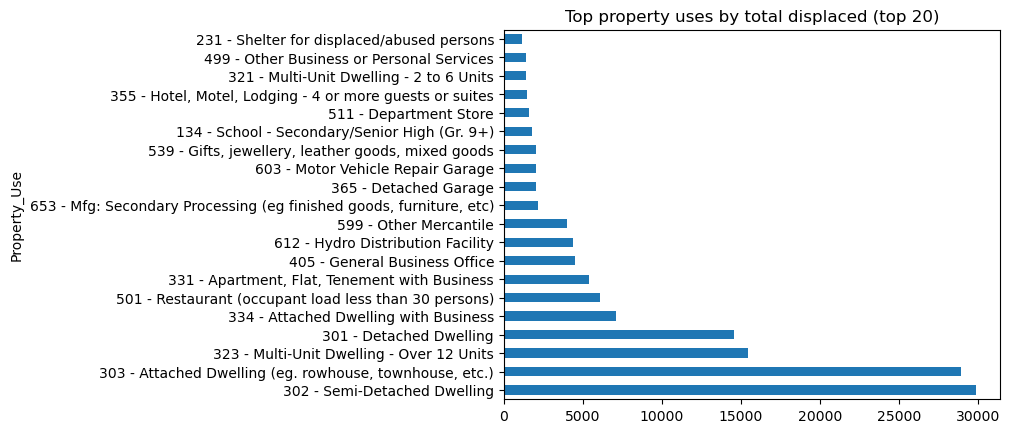

In [20]:
# 9) Displacement by property use
if "Property_Use" in df.columns:
    df["Estimated_Number_Of_Persons_Displaced"] = pd.to_numeric(df.get("Estimated_Number_Of_Persons_Displaced"), errors="coerce").fillna(0)
    q9 = df.groupby("Property_Use")["Estimated_Number_Of_Persons_Displaced"].sum().reset_index().sort_values("Estimated_Number_Of_Persons_Displaced", ascending=False)
    save_csv(q9, "displaced_by_property")
    fig = plt.figure(figsize=(8,6))
    top = q9.head(20).set_index("Property_Use")
    top.plot(kind="barh", legend=False)
    plt.title("Top property uses by total displaced (top 20)")
    save_plot(fig, "displaced_by_property_top20")

In [21]:
# 10) Rescue vs resources
if "Count_of_Persons_Rescued" in df.columns:
    df["Count_of_Persons_Rescued"] = pd.to_numeric(df["Count_of_Persons_Rescued"], errors="coerce").fillna(0)
    q10 = df.groupby(["Number_of_responding_apparatus","Number_of_responding_personnel"])["Count_of_Persons_Rescued"].sum().reset_index().sort_values("Count_of_Persons_Rescued", ascending=False).head(50)
    save_csv(q10, "rescue_vs_resources")
    fig = plt.figure(figsize=(8,5))
    plt.scatter(q10["Number_of_responding_personnel"].fillna(0), q10["Count_of_Persons_Rescued"])
    plt.xlabel("Responding Personnel"); plt.ylabel("Total Rescued")
    plt.title("Rescues vs Responding Personnel (top 50 rows)")
    save_plot(fig, "rescue_vs_resources_scatter")

Saved CSV: results\rescue_vs_resources.csv
Saved plot: plots\rescue_vs_resources_scatter.png


In [22]:
# 11 casualty rate per property use (total casualties / incidents)
if "Property_Use" in df.columns and "Civilian_Casualties" in df.columns:
    tmp = df.groupby("Property_Use").agg(Incidents=("Area_of_Origin","count"), Total_Casualties=("Civilian_Casualties","sum")).reset_index()
    tmp["Casualty_Rate_per_Incident"] = tmp["Total_Casualties"] / tmp["Incidents"].replace(0,np.nan)
    q13 = tmp.sort_values("Casualty_Rate_per_Incident", ascending=False).head(30)
    save_csv(q13, "casualty_rate_by_property")
    fig = plt.figure(figsize=(8,6))
    plt.barh(q13["Property_Use"][::-1].astype(str), q13["Casualty_Rate_per_Incident"][::-1])
    plt.title("Casualty rate per incident by property use (top 30)")
    save_plot(fig, "casualty_rate_by_property")

Saved CSV: results\casualty_rate_by_property.csv
Saved plot: plots\casualty_rate_by_property.png


In [23]:
# 12) incidents with firefighter casualties
if "TFS_Firefighter_Casualties" in df.columns:
    q14 = df[df["TFS_Firefighter_Casualties"].fillna(0) > 0]
    save_csv(q14, "incidents_firefighter_casualties")
    fig = plt.figure(figsize=(8,4))
    plt.bar([0], [len(q14)])
    plt.title("Number of incidents with firefighter casualties")
    save_plot(fig, "incidents_firefighter_casualties_count")

Saved CSV: results\incidents_firefighter_casualties.csv
Saved plot: plots\incidents_firefighter_casualties_count.png


In [25]:
# 13) incidents by hour of day
if "TFS_Alarm_Time" in df.columns:
    df["Hour"] = df["TFS_Alarm_Time"].dt.hour
    q15 = df["Hour"].value_counts().sort_index().reset_index()
    q15.columns = ["Hour","Incidents"]
    save_csv(q15, "incidents_by_hour")
    fig = plt.figure(figsize=(8,4))
    plt.plot(q15["Hour"], q15["Incidents"], marker='o')
    plt.title("Incidents by Hour of Day")
    plt.xlabel("Hour"); plt.ylabel("Incidents")
    save_plot(fig, "incidents_by_hour")

Saved CSV: results\incidents_by_hour.csv
Saved plot: plots\incidents_by_hour.png


In [26]:
# 14) median response time by Area_of_Origin
if "Response_Minutes" in df.columns and "Area_of_Origin" in df.columns:
    q16 = df.groupby("Area_of_Origin")["Response_Minutes"].median().dropna().sort_values().reset_index().tail(20)
    q16.columns = ["Area_of_Origin","Median_Response_Minutes"]
    save_csv(q16, "median_response_by_area_top20")
    fig = plt.figure(figsize=(8,6))
    plt.barh(q16["Area_of_Origin"][::-1], q16["Median_Response_Minutes"][::-1])
    plt.title("Median response minutes by area (top 20 by median)")
    save_plot(fig, "median_response_by_area_top20")

Saved CSV: results\median_response_by_area_top20.csv
Saved plot: plots\median_response_by_area_top20.png


In [27]:
# 15) correlation between Estimated_Dollar_Loss and Minutes_To_Control
if "Estimated_Dollar_Loss" in df.columns and "Minutes_To_Control" in df.columns:
    tmp = df[["Estimated_Dollar_Loss","Minutes_To_Control"]].dropna()
    if len(tmp) > 2:
        corr = np.corrcoef(tmp["Estimated_Dollar_Loss"], tmp["Minutes_To_Control"])[0,1]
    else:
        corr = np.nan
    save_csv(pd.DataFrame({"corr_loss_minutes_to_control":[corr]}), "corr_loss_vs_time_to_control")
    fig = plt.figure(figsize=(6,6))
    plt.scatter(tmp["Minutes_To_Control"], tmp["Estimated_Dollar_Loss"].clip(upper=1e7))
    plt.xlabel("Minutes_To_Control"); plt.ylabel("Estimated_Dollar_Loss (clipped)")
    plt.title(f"Correlation loss vs time to control: {corr:.3f}")
    save_plot(fig, "corr_loss_vs_time")

Saved CSV: results\corr_loss_vs_time_to_control.csv
Saved plot: plots\corr_loss_vs_time.png


In [28]:
# 18) percent with smoke alarm present
if "Smoke_Alarm_at_Fire_Origin" in df.columns:
    counts = df["Smoke_Alarm_at_Fire_Origin"].value_counts(dropna=False)
    present = counts.get("4 - Floor/suite of fire origin: Smoke alarm present", None) or counts.get("1", None)  # try label variants
    total = len(df)
    percent_present = (counts.sum() and (counts.get("4 - Floor/suite of fire origin: Smoke alarm present",0) / total*100)) if total>0 else np.nan
    # fallback: compute any non-null and not 'NULL' as present
    # Better: compute rows where Smoke_Alarm_at_Fire_Origin contains 'present'
    present_rows = df["Smoke_Alarm_at_Fire_Origin"].astype(str).str.lower().str.contains("present", na=False).sum()
    percent_present = present_rows / total * 100 if total>0 else np.nan
    save_csv(pd.DataFrame({"percent_smoke_alarm_present":[percent_present]}), "percent_smoke_alarm_present")
    fig = plt.figure(figsize=(4,4))
    plt.pie([percent_present, 100-percent_present], labels=[f"present ({percent_present:.1f}%)","not present"], autopct="%1.1f%%")
    plt.title("Smoke alarm present %")
    save_plot(fig, "percent_smoke_alarm_present")

Saved CSV: results\percent_smoke_alarm_present.csv
Saved plot: plots\percent_smoke_alarm_present.png
